# 1 Import packages and load methods

In [1]:
import Ipynb_importer

In [3]:
import TrodesReader
# import from https://bitbucket.org/mkarlsso/trodes/src/master/ or pip install trodesnetwork
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from pprint import pprint
import scipy

In [4]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y


def calculate_rms(buffer):
    square_summed = 0
    for k in buffer:
        square_summed += (k ** 2)

    return math.sqrt(square_summed / len(buffer))


def filter_then_rms(buffer, low_cut, high_cut, threshold):
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    return current_rms >= threshold

# 2 Load Data and Initial Processing

## 2.1 Load Data

In [5]:
# this is the 40 min data : 20211207_E1_124311 
# nTrode used: 28

# Sameera's data path
'''
data_path_28 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt28ch1.dat'
data_path_27 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt27ch1.dat'
data_path_29 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt29ch1.dat'
time_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.timestamps.dat'
'''

# Jhan's data path
data_path_28 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt28ch1.dat"
data_path_27 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt27ch1.dat"
data_path_29 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt29ch1.dat"
time_path = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.timestamps.dat"

In [6]:
# this is the 40 min data : 20211207_E1_124311 
# nTrode used: 28

data = TrodesReader.readTrodesExtractedDataFile(data_path_28)
#pprint(data)
time = TrodesReader.readTrodesExtractedDataFile(time_path)
#pprint(time)

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


## 2.2 Convert time frame

In [7]:
start_time = int(time['first_timestamp'])
time_data = []
for i in time['data']:
    time_data.append((i[0]-start_time)/30000)

## 2.3 Parameters and Filtering

In [8]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

sw_lower = 5
sw_upper = 15
ripple_lower = 150
ripple_upper = 250

offline_hilbert_numstd = 10
noise_hilbert_numstd = 5
offline_rms_numstd = 4
online_rms_numstd = 4

In [9]:
all_data = data['data']
lfp_data = []
for i in all_data:
    lfp_data.append(i[0])

ripple_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
Noise_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 500, 600)

# 3 Offline&Noise Processing with Hilbert

## 3.1 Hilbert Transform

In [10]:
offline_hilbert_analytic = scipy.signal.hilbert(ripple_lfp_data)
offline_hilbert_magnitude = np.abs(offline_hilbert_analytic)

In [11]:
noise_hilbert_analytic = scipy.signal.hilbert(Noise_data)
noise_hilbert_magnitude = np.abs(noise_hilbert_analytic)

<IPython.core.display.Javascript object>


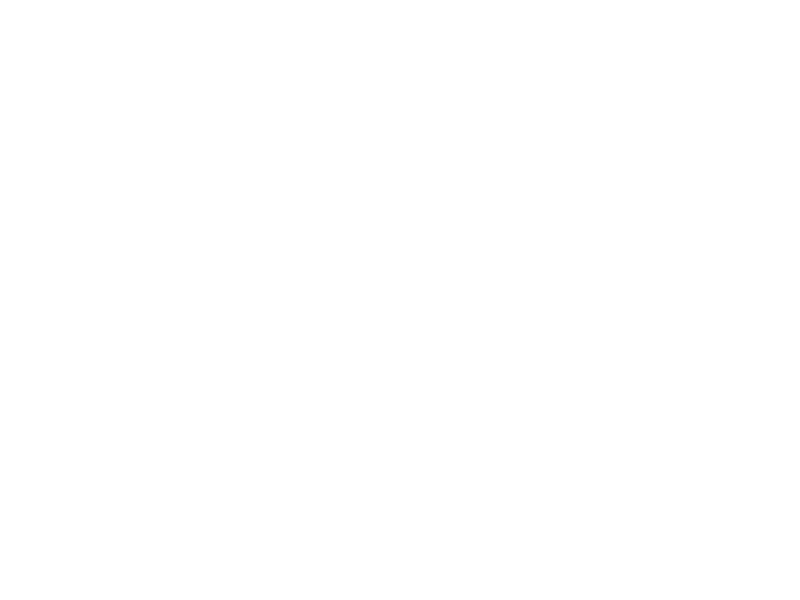

In [12]:
#Ripple-range data, Noise-range data against Raw Data (with Hilbert)
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k',label='Raw Data')
plt.plot(time_data,offline_hilbert_magnitude,color='b',label='Ripple Range Hilbert')
plt.plot(time_data,noise_hilbert_magnitude,color='r',label='Noise Range Hilbert')
#plt.xlabel('Time(s)')
#plt.ylabel('Power')
#plt.legend()
#plt.title('Unprocessed Ripple data, Noise data and Raw Data (with Hilbert)')
plt.show()

## 3.2 Noise Events Detection

In [13]:
noise_hilbert_avg = np.mean(noise_hilbert_magnitude)
noise_hilbert_std = np.std(noise_hilbert_magnitude)

print('Noise average:'+str(noise_hilbert_avg))
print('Noise standard deviation:'+str(noise_hilbert_std))

noise_hilbert_zscore = []
for i in range(0,len(noise_hilbert_magnitude)):
    noise_hilbert_zscore.append((noise_hilbert_magnitude[i]-noise_hilbert_avg)/noise_hilbert_std)

Noise average:3.475338633938571
Noise standard deviation:15.731873111808346


In [14]:
noise_hilbert_decision = []
for i in range(0,len(noise_hilbert_magnitude)):
    noise_hilbert_decision.append(noise_hilbert_zscore[i]>noise_hilbert_numstd)

noise_hilbert_decarr = np.array(noise_hilbert_decision)

## 3.3 Offline(Hilbert) Denoising

In [15]:
offline_hilbert_denoised = []
offline_hilbert_time = []
for i in range(0,len(offline_hilbert_magnitude)):
    if ((not noise_hilbert_decarr[i]) and (offline_hilbert_magnitude[i]<=1000)):
    # if not labelled as noise samples and magnitude not larger than 1000
        offline_hilbert_denoised.append(offline_hilbert_magnitude[i])
        offline_hilbert_time.append(time_data[i])

## 3.4 Offline(Hilbert) Detection

### 3.4.1 Detect with Denoised Offline(Hilbert) Data

In [16]:
offline_hilbert_avg = np.mean(offline_hilbert_denoised)
offline_hilbert_std = np.std(offline_hilbert_denoised)
offline_hilbert_threshold = offline_hilbert_avg + offline_hilbert_numstd*offline_hilbert_std
print('Offline average:'+str(offline_hilbert_avg))
print('Offline standard deviation:'+str(offline_hilbert_std))
print('Offline threshold:'+str(offline_hilbert_threshold))

Offline average:37.32408532721501
Offline standard deviation:39.9641851418823
Offline threshold:436.965936746038


In [17]:
offline_hilbert_zscore = []

for i in range(0,len(offline_hilbert_denoised)):
    offline_hilbert_zscore.append((offline_hilbert_denoised[i]-offline_hilbert_avg)/offline_hilbert_std)

<IPython.core.display.Javascript object>


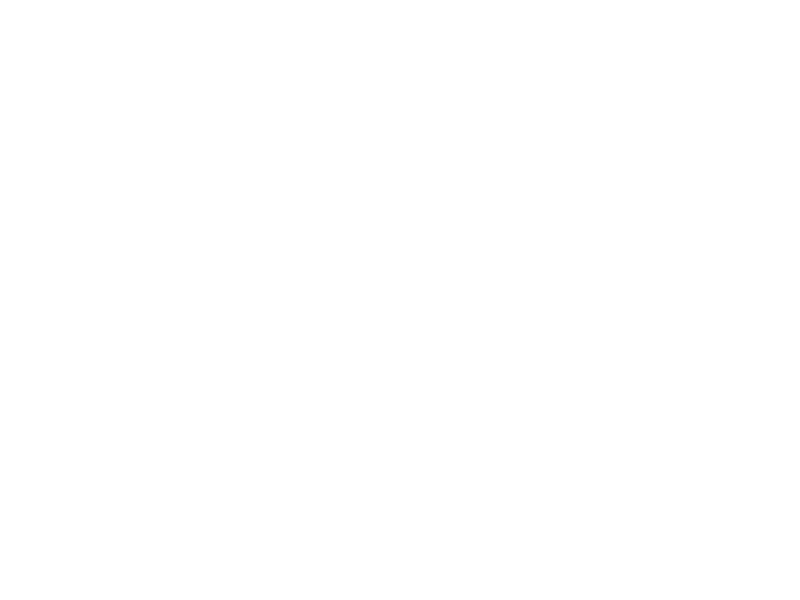

In [18]:
%matplotlib notebook
plt.figure()
plt.plot(offline_hilbert_time,offline_hilbert_zscore,label='Z-scored Ripple Data')
plt.plot(time_data,noise_hilbert_decarr*10,color='r',alpha=0.4,label='Z-scored Noise Data')
#plt.xlabel('Time(s)')
#plt.ylabel('Power')
#plt.legend()
#plt.title('Z-scored Ripple and Noise Data (with Hilbert)')
plt.show()

In [19]:
offline_hilbert_decision = [False, False]
offline_hilbert_stimulation = []

for i in range(0,len(offline_hilbert_denoised)):
    offline_hilbert_decision.append(offline_hilbert_denoised[i]>offline_hilbert_threshold)
    current_stimulation = True
    for m in range(len(offline_hilbert_decision)-3,len(offline_hilbert_decision)):
        if not offline_hilbert_decision[m]:
            current_stimulation = False
    offline_hilbert_stimulation.append(current_stimulation) 

offline_hilbert_stimarr = np.array(offline_hilbert_stimulation)

<IPython.core.display.Javascript object>


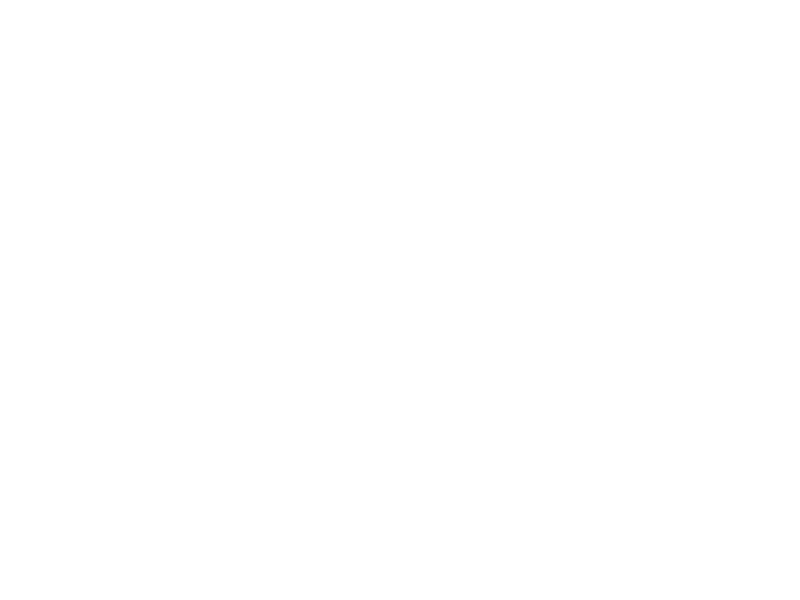

In [20]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,label='Raw Data')
plt.plot(offline_hilbert_time,offline_hilbert_stimarr*3000,color='r',label='Offline(Hilbert) Decision')
#plt.xlabel('Time(s)')
#plt.ylabel('Power')
#plt.title('Offline(Hilbert) Decisions Against Denoised Ripple Data')
#plt.legend()
plt.show()

### 3.4.2 Detect with Offline(Hilbert) Data (no denoising)

In [21]:
offline_hilbert_avg_raw = np.mean(offline_hilbert_magnitude)
offline_hilbert_std_raw = np.std(offline_hilbert_magnitude)
offline_hilbert_threshold_raw = offline_hilbert_avg_raw + offline_hilbert_numstd*offline_hilbert_std_raw
print('Offline average_raw:'+str(offline_hilbert_avg_raw))
print('Offline standard deviation_raw:'+str(offline_hilbert_std_raw))
print('Offline threshold_raw:'+str(offline_hilbert_threshold_raw))

Offline average_raw:38.953030558912666
Offline standard deviation_raw:103.5786800851262
Offline threshold_raw:1074.7398314101745


In [22]:
offline_hilbert_decision_raw = [False, False]
offline_hilbert_stimulation_raw = []

for i in range(0,len(offline_hilbert_magnitude)):
    offline_hilbert_decision_raw.append(offline_hilbert_magnitude[i]>offline_hilbert_threshold_raw)
    current_stimulation = True
    for m in range(len(offline_hilbert_decision_raw)-3,len(offline_hilbert_decision_raw)):
        if not offline_hilbert_decision_raw[m]:
            current_stimulation = False
    offline_hilbert_stimulation_raw.append(current_stimulation) 

offline_hilbert_stimarr_raw = np.array(offline_hilbert_stimulation_raw)

<IPython.core.display.Javascript object>


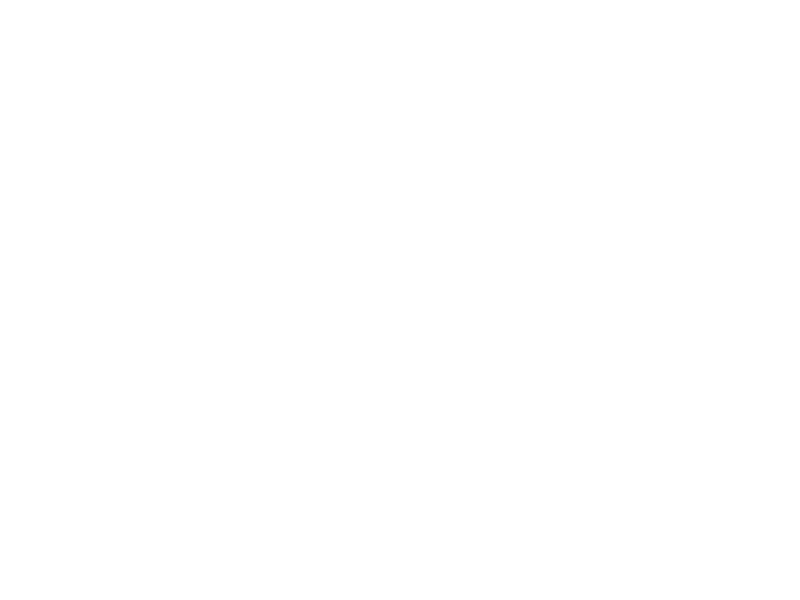

In [23]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,label='Raw Data')
plt.plot(time_data,offline_hilbert_stimarr_raw*3000,color='r',label='Offline(Hilbert) Decision')
#plt.xlabel('Time(s)')
#plt.ylabel('Power')
#plt.title('Offline(Hilbert) Decisions Against Denoised Ripple Data')
#plt.legend()
plt.show()

## 3.5 Offline(Hilbert) Deblipping

### 3.5.1 Deblipping denoised Offline(Hilbert) data

In [24]:
offline_hilbert_changedtime = []
for i in range(1,len(offline_hilbert_stimulation)):
    previous = offline_hilbert_stimulation[i-1]
    if previous != offline_hilbert_stimulation[i]:
        offline_hilbert_changedtime.append(offline_hilbert_time[i])

In [25]:
offline_hilbert_eventduration = []
for i in range(0,len(offline_hilbert_changedtime)-1,2):
    offline_hilbert_eventduration.append((offline_hilbert_changedtime[i+1]-offline_hilbert_changedtime[i])*1000)

<IPython.core.display.Javascript object>


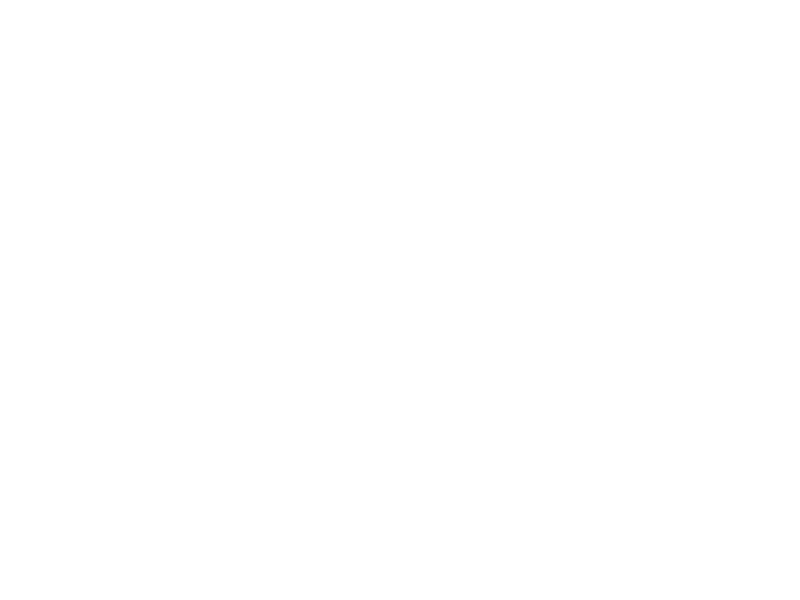

In [26]:
diffbar_hilbert, bin_edges_hilbert = np.histogram(offline_hilbert_eventduration, range(-50,200))
plt.figure()
plt.bar(bin_edges_hilbert[:-1],diffbar_hilbert)
#plt.xlabel("Event Duration (ms)")
#plt.ylabel("Frequency")
#plt.title("Offline(Hilbert) Event Duration (%d Events, Unprocessed)"%len(hilberttimetrue))
plt.show()

In [27]:
offline_hilbert_truetime = []
for i in range(0,len(offline_hilbert_changedtime),2):
    offline_hilbert_truetime.append(offline_hilbert_changedtime[i])

print('After denoising, # of Offline(Hilbert) events:'+str(len(offline_hilbert_truetime)))

After denoising, # of Offline(Hilbert) events:427


In [28]:
offline_hilbert_deblipped = []
offline_hilbert_lenthreshold = 0.05 #30

'''
for i in range(0,len(offline_hilbert_truetime)):
    if(offline_hilbert_eventduration[i]>=offline_hilbert_lenthreshold):
        offline_hilbert_deblipped.append(offline_hilbert_truetime[i])
'''

offline_hilbert_deblipped.append(offline_hilbert_truetime[0])
for i in range(1,len(offline_hilbert_truetime)):
    if((offline_hilbert_truetime[i]-offline_hilbert_truetime[i-1])>offline_hilbert_lenthreshold):
        offline_hilbert_deblipped.append(offline_hilbert_truetime[i])
             
print('After deblipping and deblipping, # of Offline(Hilbert) events:'+str(len(offline_hilbert_deblipped)))

After deblipping and deblipping, # of Offline(Hilbert) events:354


<IPython.core.display.Javascript object>


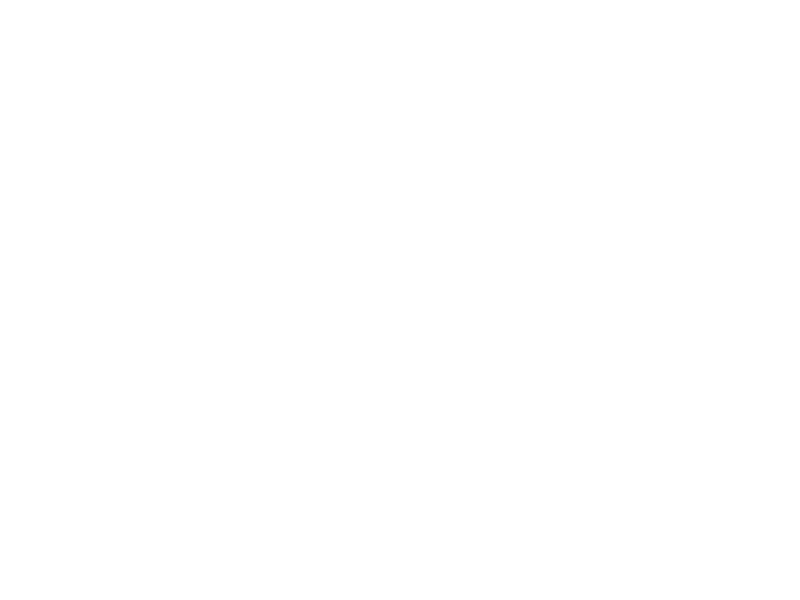

In [29]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_hilbert_deblipped,np.array([True]*len(offline_hilbert_deblipped))*5000,color='r')
plt.show()

### 3.5.2 Deblipping Offline(Hilbert) data (no denoising)

In [30]:
offline_hilbert_changedtime_raw = []
for i in range(1,len(offline_hilbert_stimulation_raw)):
    previous = offline_hilbert_stimulation_raw[i-1]
    if previous != offline_hilbert_stimulation_raw[i]:
        offline_hilbert_changedtime_raw.append(time_data[i])

In [31]:
offline_hilbert_eventduration_raw = []
for i in range(0,len(offline_hilbert_changedtime_raw)-1,2):
    offline_hilbert_eventduration_raw.append((offline_hilbert_changedtime_raw[i+1]-offline_hilbert_changedtime_raw[i])*1000)

<IPython.core.display.Javascript object>


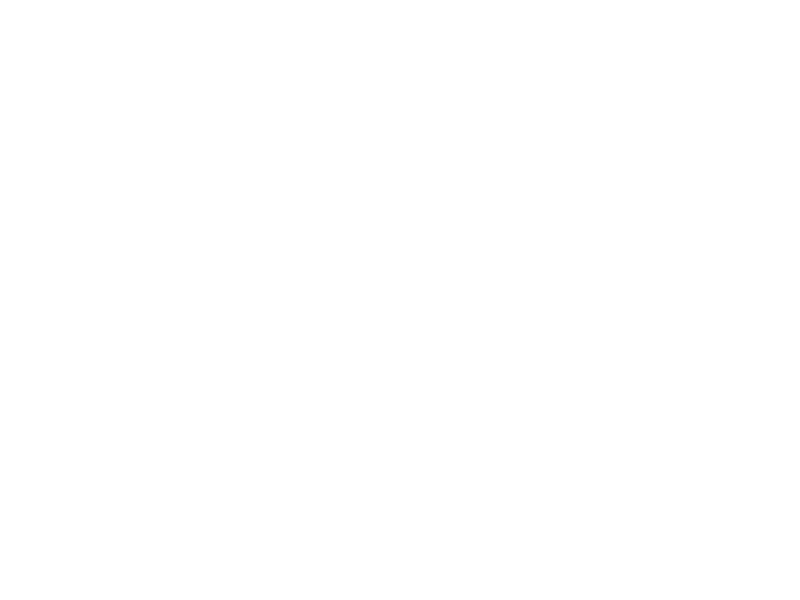

In [32]:
diffbar_raw, bin_edges_raw = np.histogram(offline_hilbert_eventduration_raw, range(-50,150))
plt.figure()
plt.bar(bin_edges_raw[:-1],diffbar_raw)
plt.show()

In [33]:
offline_hilbert_truetime_raw = []
for i in range(0,len(offline_hilbert_changedtime_raw),2):
    offline_hilbert_truetime_raw.append(offline_hilbert_changedtime_raw[i])
    
print('# of Offline(Hilbert) events:'+str(len(offline_hilbert_truetime_raw)))

# of Offline(Hilbert) events:62


In [34]:
offline_hilbert_deblipped_raw = []
offline_hilbert_lenthreshold_raw = 0.05

'''
for i in range(0,len(offline_hilbert_truetime_raw)):
    if(offline_hilbert_eventduration_raw[i]>=offline_hilbert_lenthreshold_raw):
        offline_hilbert_deblipped_raw.append(offline_hilbert_truetime_raw[i])
'''

offline_hilbert_deblipped_raw.append(offline_hilbert_truetime_raw[0])
for i in range(1,len(offline_hilbert_truetime_raw)):
    if((offline_hilbert_truetime_raw[i]-offline_hilbert_truetime_raw[i-1])>offline_hilbert_lenthreshold_raw):
        offline_hilbert_deblipped_raw.append(offline_hilbert_truetime_raw[i])
        
print('After deblipping, # of Offline(Hilbert) events:'+str(len(offline_hilbert_deblipped_raw)))

After deblipping, # of Offline(Hilbert) events:33


<IPython.core.display.Javascript object>


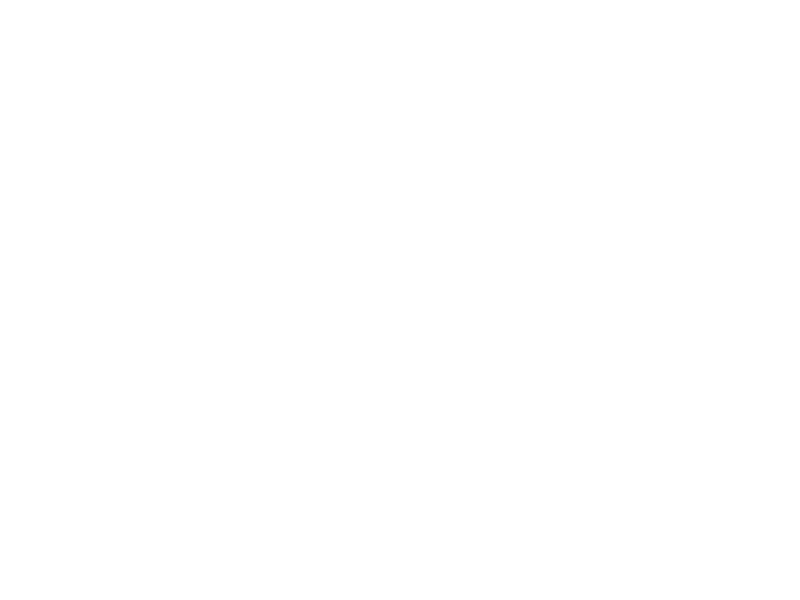

In [35]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_hilbert_deblipped_raw,np.array([True]*len(offline_hilbert_deblipped_raw))*5000,color='r')
plt.show()

# 4 Offline Processing with RMS

## 4.1 Offline RMS (all ripple data)

In [36]:
offline_rms_magnitude = []
offline_rms_time = []
for i in range(149,len(ripple_lfp_data)):
    current_buffer = ripple_lfp_data[i-149:i]
    current_rms = calculate_rms(current_buffer)
    if(current_rms<=300):
        offline_rms_magnitude.append(current_rms)
        offline_rms_time.append(time_data[i])

In [37]:
offline_rms_avg = np.mean(offline_rms_magnitude)
offline_rms_std = np.std(offline_rms_magnitude)
offline_rms_threshold = offline_rms_avg + offline_rms_numstd*offline_rms_std
print('Offline average:'+str(offline_rms_avg))
print('Offline standard deviation:'+str(offline_rms_std))
print('Offline threshold:'+str(offline_rms_threshold))

Offline average:31.045511973041833
Offline standard deviation:22.59039460513694
Offline threshold:121.40709039358958


In [38]:
offline_rms_zscore = []
for i in offline_rms_magnitude:
    offline_rms_zscore.append((i-offline_rms_avg)/offline_rms_std)

<IPython.core.display.Javascript object>


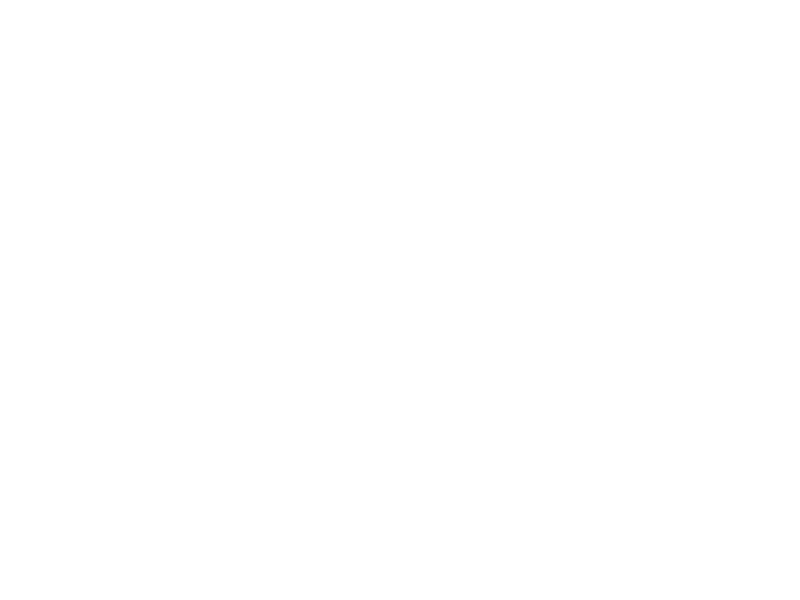

In [39]:
plt.figure()
#plt.plot(time_data,lfp_data,color='k')
plt.plot(offline_rms_time,offline_rms_magnitude,color='b')

## 4.2 Offline(RMS) Detection

In [40]:
offline_rms_decision = [False, False]
offline_rms_stimulation = []

for i in range(0,len(offline_rms_magnitude)):
    offline_rms_decision.append(offline_rms_magnitude[i]>offline_rms_threshold)
    current_stimulation = True
    for m in range(len(offline_rms_decision)-3,len(offline_rms_decision)):
        if not offline_rms_decision[m]:
            current_stimulation = False
    offline_rms_stimulation.append(current_stimulation)

offline_rms_stimarr = np.array(offline_rms_stimulation)

<IPython.core.display.Javascript object>


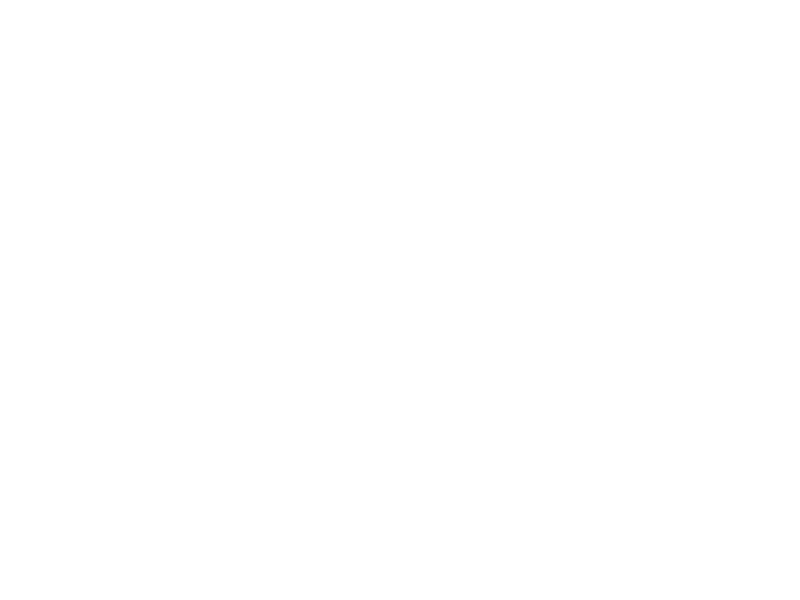

In [41]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='b')
plt.plot(offline_rms_time,offline_rms_stimarr*6000,color='r')
#plt.xlabel('Time')
#plt.ylabel('Power')
#plt.legend()
plt.show()

## 4.3 Offline(RMS) Deblipping

In [42]:
offline_rms_changedtime = []
for i in range(1,len(offline_rms_stimarr)):
    previous = offline_rms_stimarr[i-1]
    if previous != offline_rms_stimarr[i]:
        offline_rms_changedtime.append(offline_rms_time[i])

In [43]:
offline_rms_eventduration = []
for i in range(0,len(offline_rms_changedtime)-1,2):
    offline_rms_eventduration.append((offline_rms_changedtime[i+1]-offline_rms_changedtime[i])*1000)

<IPython.core.display.Javascript object>


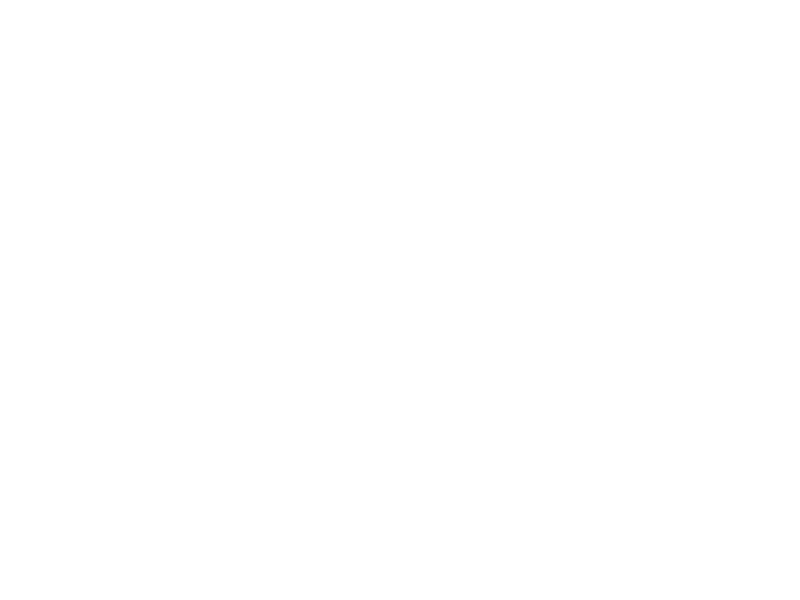

In [44]:
diffbar_rms, bin_edges_rms = np.histogram(offline_rms_eventduration, range(-20,210))
plt.figure()
plt.bar(bin_edges_rms[:-1],diffbar_rms)
plt.show()

In [45]:
offline_rms_truetime = []
for i in range(0,len(offline_rms_changedtime),2):
    offline_rms_truetime.append(offline_rms_changedtime[i])
    
print('With denoising, # of Offline(RMS) events:'+str(len(offline_rms_truetime)))

With denoising, # of Offline(RMS) events:392


In [46]:
offline_rms_deblipped = []
offline_rms_lenthreshold = 50
for i in range(0,len(offline_rms_truetime)):
    if(offline_rms_eventduration[i]>=offline_rms_lenthreshold):
        offline_rms_deblipped.append(offline_rms_truetime[i])
        
print('After deblipping, # of Offline(RMS) events:'+str(len(offline_rms_deblipped)))

After deblipping, # of Offline(RMS) events:344


<IPython.core.display.Javascript object>


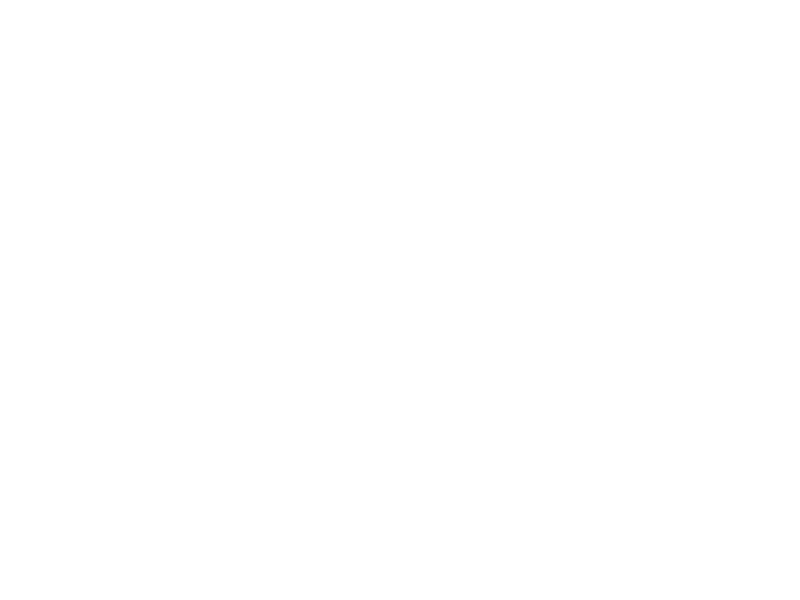

In [47]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(offline_rms_deblipped,np.array([True]*len(offline_rms_deblipped))*5000,color='r')
plt.show()

# 5 Online RMS Processing

## 5.1 Online RMS (buffers)

In [48]:
online_rms_magnitude = []
online_rms_time = []
for i in range(149,len(lfp_data)):
    current_buffer = lfp_data[i-149:i]
    current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
    current_rms = calculate_rms(current_filtered)
    if(current_rms<=300):
        online_rms_magnitude.append(current_rms)
        online_rms_time.append(time_data[i])

In [49]:
online_rms_avg = np.mean(online_rms_magnitude)
online_rms_std = np.std(online_rms_magnitude)
online_rms_threshold = online_rms_avg + online_rms_numstd*online_rms_std
print('Online RMS average:'+str(online_rms_avg))
print('Online RMS standard deviation:'+str(online_rms_std))
print('Online RMS threshold:'+str(online_rms_threshold))

Online RMS average:30.76240742946608
Online RMS standard deviation:22.377687596119525
Online RMS threshold:120.27315781394418


In [50]:
online_rms_zscore = []

for i in range(0,len(online_rms_magnitude)):
    online_rms_zscore.append((online_rms_magnitude[i]-online_rms_avg)/online_rms_std)

## 5.2 Online RMS Detection

In [51]:
online_rms_decision = [False, False]
online_rms_stimulation = []

for i in range(0,len(online_rms_magnitude)):
    online_rms_decision.append(online_rms_magnitude[i]>online_rms_threshold)
    current_stimulation = True
    for m in range(len(online_rms_decision)-3,len(online_rms_decision)):
        if not online_rms_decision[m]:
            current_stimulation = False
    online_rms_stimulation.append(current_stimulation)  

In [52]:
online_rms_stimarr = np.array(online_rms_stimulation)

<IPython.core.display.Javascript object>


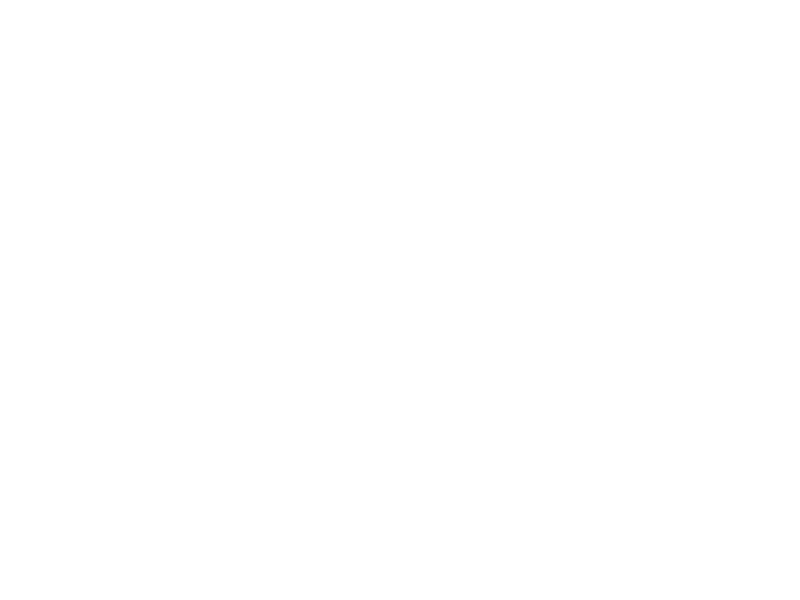

In [53]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data)
plt.plot(online_rms_time,online_rms_stimarr*6000,color='r',alpha=0.8)
#plt.xlabel('Time')
#plt.ylabel('Power')
#plt.legend()
plt.show()

## 5.3 Online RMS Deblipping

In [54]:
online_rms_changedtime = []

for i in range(1,len(online_rms_stimarr)):
    previous = online_rms_stimarr[i-1]
    if previous != online_rms_stimarr[i]:
        online_rms_changedtime.append(online_rms_time[i])

In [55]:
online_rms_eventduration = []

for i in range(0,len(online_rms_changedtime)-1,2):
    online_rms_eventduration.append((online_rms_changedtime[i+1]-online_rms_changedtime[i])*1000)

<IPython.core.display.Javascript object>


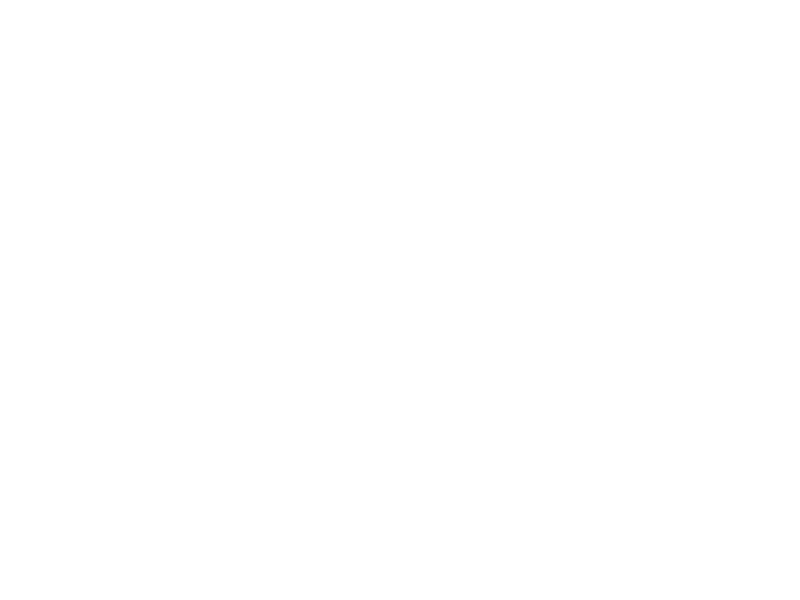

In [56]:
diffbar_online, bin_edges_online = np.histogram(online_rms_eventduration, range(-20,200))
plt.figure()
plt.bar(bin_edges_online[:-1],diffbar_online)
plt.show()

In [57]:
online_rms_truetime = []
for i in range(0,len(online_rms_changedtime),2):
    online_rms_truetime.append(online_rms_changedtime[i])
    
print('# of Online RMS events: '+str(len(online_rms_truetime)))

# of Online RMS events: 535


In [58]:
online_rms_deblipped = []
online_rms_lenthreshold = 50
for i in range(0,len(online_rms_truetime)):
    if(online_rms_eventduration[i]>=online_rms_lenthreshold):
        online_rms_deblipped.append(online_rms_truetime[i])
        
print('After deblipping, # of Online(RMS) events:'+str(len(online_rms_deblipped)))

After deblipping, # of Online(RMS) events:343


<IPython.core.display.Javascript object>


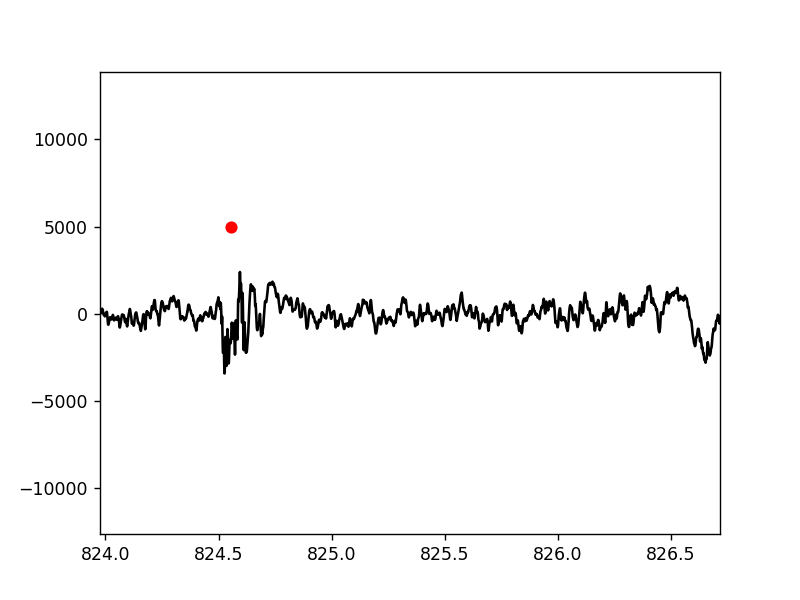

In [59]:
%matplotlib notebook
plt.figure()
plt.plot(time_data,lfp_data,color='k')
#plt.plot(time_data,ripple_lfp_data,color='b')
plt.scatter(online_rms_deblipped,np.array([True]*len(online_rms_deblipped))*5000,color='r')
plt.show()

# 6 Accuracy and Precision

## 6.1 Online(RMS) vs. Offline(Hilbert)

In [60]:
# this means using offline(hilbert) as ground truth
offline_hilbert_truepositive = []
offline_hilbert_falsepositive = []

for i in range(0,len(online_rms_deblipped)):
    cnt = 0
    for j in range(0,len(offline_hilbert_deblipped)):
        if(abs(online_rms_deblipped[i]-offline_hilbert_deblipped[j])<0.03):
            break
        cnt += 1
    if(cnt<len(offline_hilbert_deblipped)):
        offline_hilbert_truepositive.append(online_rms_deblipped[i])
    else:
        offline_hilbert_falsepositive.append(online_rms_deblipped[i])

In [61]:
print('# of Online stimulations categorized as TP:'+str(len(offline_hilbert_truepositive)))
print('# of Online stimulations categorized as FP:'+str(len(offline_hilbert_falsepositive)))

# of Online stimulations categorized as TP:273
# of Online stimulations categorized as FP:70


In [62]:
offline_hilbert_accuracy = (len(offline_hilbert_truepositive)/len(offline_hilbert_deblipped))*100
offline_hilbert_precision = (len(offline_hilbert_truepositive)/(len(offline_hilbert_truepositive)\
                                                               +len(offline_hilbert_falsepositive)))*100
print('Accuracy with Offline(Hilbert): '+str(offline_hilbert_accuracy))
print('Precision with Offline(Hilbert): '+str(offline_hilbert_precision))

Accuracy with Offline(Hilbert): 77.11864406779661
Precision with Offline(Hilbert): 79.59183673469387


## 6.2 Online(RMS) vs. Offline(Hilbert)_raw

In [63]:
# this means using offline(hilbert)_raw as ground truth
offline_hilbert_truepositive_raw = []
offline_hilbert_falsepositive_raw = []

for i in range(0,len(online_rms_deblipped)):
    cnt = 0
    for j in range(0,len(offline_hilbert_deblipped_raw)):
        if(abs(online_rms_deblipped[i]-offline_hilbert_deblipped_raw[j])<0.03):
            break
        cnt += 1
    if(cnt<len(offline_hilbert_deblipped_raw)):
        offline_hilbert_truepositive_raw.append(online_rms_deblipped[i])
    else:
        offline_hilbert_falsepositive_raw.append(online_rms_deblipped[i])

In [64]:
print('# of Online stimulations categorized as TP:'+str(len(offline_hilbert_truepositive_raw)))
print('# of Online stimulations categorized as FP:'+str(len(offline_hilbert_falsepositive_raw)))

# of Online stimulations categorized as TP:6
# of Online stimulations categorized as FP:337


In [65]:
offline_hilbert_accuracy_raw = (len(offline_hilbert_truepositive_raw)/len(offline_hilbert_deblipped_raw))*100
offline_hilbert_precision_raw = (len(offline_hilbert_truepositive_raw)/(len(offline_hilbert_truepositive_raw)\
                                                               +len(offline_hilbert_falsepositive_raw)))*100
print('Accuracy with Offline(Hilbert)_raw: '+str(offline_hilbert_accuracy_raw))
print('Precision with Offline(Hilbert)_raw: '+str(offline_hilbert_precision_raw))

Accuracy with Offline(Hilbert)_raw: 18.181818181818183
Precision with Offline(Hilbert)_raw: 1.749271137026239


## 6.3 Online(RMS) vs. Offline(RMS)

In [66]:
# this means using offline(rms) as ground truth
offline_rms_truepositive = []
offline_rms_falsepositive = []

for i in range(0,len(online_rms_deblipped)):
    cnt = 0
    for j in range(0,len(offline_rms_deblipped)):
        if(abs(online_rms_deblipped[i]-offline_rms_deblipped[j])<0.03):
            break
        cnt += 1
    if(cnt<len(offline_rms_deblipped)):
        offline_rms_truepositive.append(online_rms_deblipped[i])
    else:
        offline_rms_falsepositive.append(online_rms_deblipped[i])

In [67]:
print('# of Online stimulations categorized as TP:'+str(len(offline_rms_truepositive)))
print('# of Online stimulations categorized as FP:'+str(len(offline_rms_falsepositive)))

# of Online stimulations categorized as TP:336
# of Online stimulations categorized as FP:7


In [68]:
offline_rms_accuracy = (len(offline_rms_truepositive)/len(offline_rms_deblipped))*100
offline_rms_precision = (len(offline_rms_truepositive)/(len(offline_rms_truepositive)\
                                                               +len(offline_rms_falsepositive)))*100
print('Accuracy with Offline(RMS): '+str(offline_rms_accuracy))
print('Precision with Offline(RMS): '+str(offline_rms_precision))

Accuracy with Offline(RMS): 97.67441860465115
Precision with Offline(RMS): 97.95918367346938


## 6.4 Overall Results

<IPython.core.display.Javascript object>


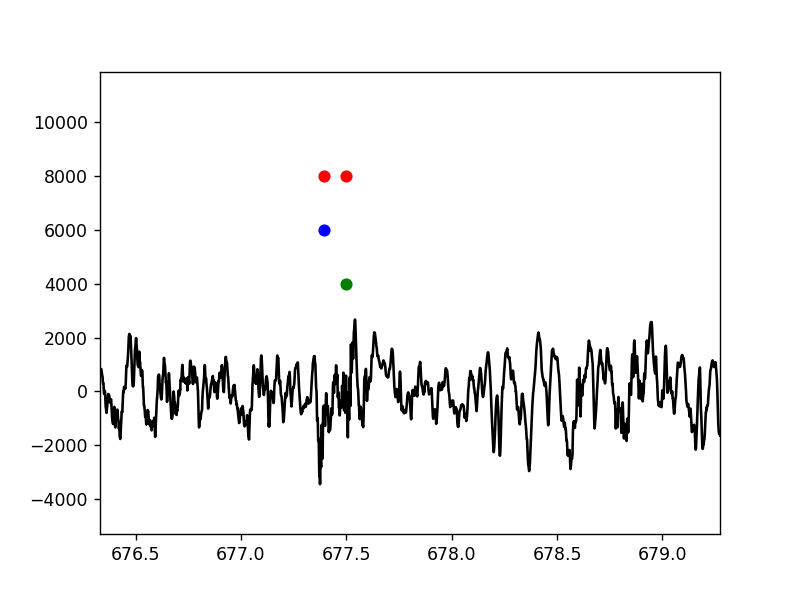

In [69]:
plt.figure()
plt.plot(time_data,lfp_data,color='k')
plt.scatter(online_rms_deblipped,np.array([True]*len(online_rms_deblipped))*8000,color='r')
plt.scatter(offline_rms_deblipped,np.array([True]*len(offline_rms_deblipped))*6000,color='b')
plt.scatter(offline_hilbert_deblipped,np.array([True]*len(offline_hilbert_deblipped))*4000,color='g')

<IPython.core.display.Javascript object>


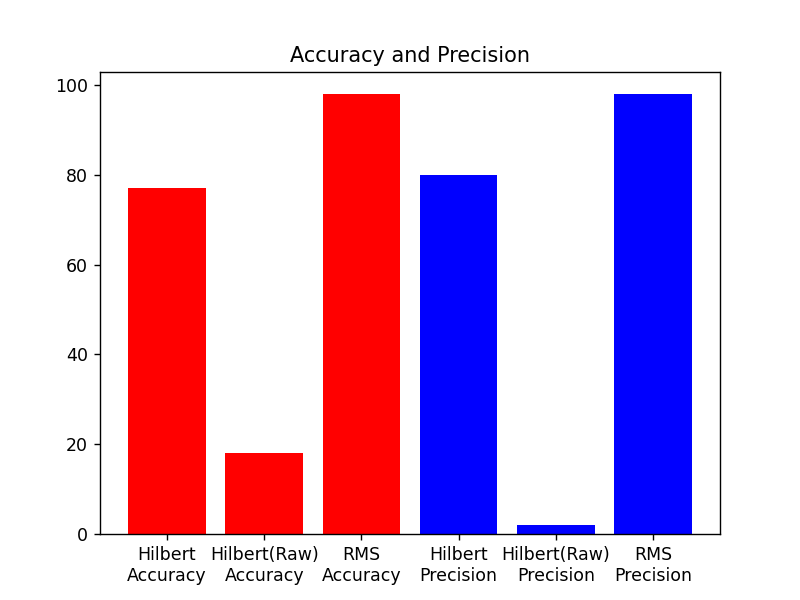

In [70]:
x_data = ['Hilbert\nAccuracy','Hilbert(Raw)\nAccuracy','RMS\nAccuracy',
          'Hilbert\nPrecision','Hilbert(Raw)\nPrecision','RMS\nPrecision']
y_data = [round(offline_hilbert_accuracy),round(offline_hilbert_accuracy_raw),round(offline_rms_accuracy),
       round(offline_hilbert_precision),round(offline_hilbert_precision_raw),round(offline_rms_precision)]

plt.figure()
plt.bar(x_data,
       y_data,
       color=['r','r','r','b','b','b'])
'''
for x_label, y_label, label in zip(x_label, y_data,y_data):
    plt.text(x_label,
             y_label,
             label,
             ha='center', 
             va='bottom')
'''
plt.title('Accuracy and Precision')
plt.show()

In [71]:
print('offline_hilbert_numstd = '+str(offline_hilbert_numstd))
print('noise_hilbert_numstd = '+str(noise_hilbert_numstd))
print('offline_rms_numstd = '+str(offline_rms_numstd))
print('online_rms_numstd = '+str(online_rms_numstd))
print('# of events with Offline(Hilbert)_denoised: '+str(len(offline_hilbert_truetime)))
print('# of events with Offline(Hilbert)_denoised_deblipped: '+str(len(offline_hilbert_deblipped)))
print('# of events with Offline(Hilbert)_raw: '+str(len(offline_hilbert_truetime_raw)))
print('# of events with Offline(Hilbert)_raw_deblipped: '+str(len(offline_hilbert_deblipped_raw)))
print('# of events with Offline(RMS): '+str(len(offline_rms_truetime)))
print('# of events with Offline(RMS)_deblipped: '+str(len(offline_rms_deblipped)))
print('# of events with Online(RMS): '+str(len(online_rms_truetime)))
print('# of events with Online(RMS)_deblipped: '+str(len(online_rms_deblipped)))
print('------------')
print('Accuracy with Offline(Hilbert): '+str(offline_hilbert_accuracy))
print('Precision with Offline(Hilbert): '+str(offline_hilbert_precision))
print('Accuracy with Offline(Hilbert)_raw: '+str(offline_hilbert_accuracy_raw))
print('Precision with Offline(Hilbert)_raw: '+str(offline_hilbert_precision_raw))
print('Accuracy with Offline(RMS): '+str(offline_rms_accuracy))
print('Precision with Offline(RMS): '+str(offline_rms_precision))

offline_hilbert_numstd = 10
noise_hilbert_numstd = 5
offline_rms_numstd = 4
online_rms_numstd = 4
# of events with Offline(Hilbert)_denoised: 427
# of events with Offline(Hilbert)_denoised_deblipped: 354
# of events with Offline(Hilbert)_raw: 62
# of events with Offline(Hilbert)_raw_deblipped: 33
# of events with Offline(RMS): 392
# of events with Offline(RMS)_deblipped: 344
# of events with Online(RMS): 535
# of events with Online(RMS)_deblipped: 343
------------
Accuracy with Offline(Hilbert): 77.11864406779661
Precision with Offline(Hilbert): 79.59183673469387
Accuracy with Offline(Hilbert)_raw: 18.181818181818183
Precision with Offline(Hilbert)_raw: 1.749271137026239
Accuracy with Offline(RMS): 97.67441860465115
Precision with Offline(RMS): 97.95918367346938


# 7 Lag Calculation

## 7.1 Cross Correlation - Offline(Hilbert) and Online(RMS)

In [72]:
offline_hilbert_onlags = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_hilbert_truetime)):
        offline_hilbert_onlags.append(round((online_rms_truetime[i]-offline_hilbert_truetime[j])*1000))

<IPython.core.display.Javascript object>


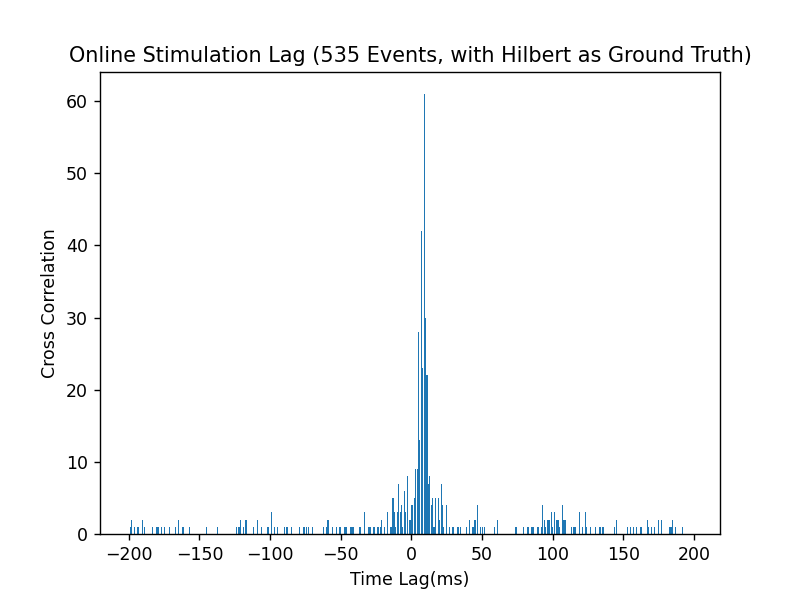

Text(0.5, 1.0, 'Online Stimulation Lag (535 Events, with Hilbert as Ground Truth)')

In [73]:
offline_hilbert_xcorrhist, offline_hilbert_binedges = np.histogram(offline_hilbert_onlags,range(-200,200))
plt.figure()
plt.bar(offline_hilbert_binedges[:-1],offline_hilbert_xcorrhist)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with Hilbert as Ground Truth)'%len(online_rms_truetime))

## 7.2 Cross Correlation - Offline(Hilbert)_raw and Online(RMS)

In [74]:
offline_hilbert_onlags_raw = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_hilbert_truetime_raw)):
        offline_hilbert_onlags_raw.append(round((online_rms_truetime[i]-offline_hilbert_truetime_raw[j])*1000))

<IPython.core.display.Javascript object>


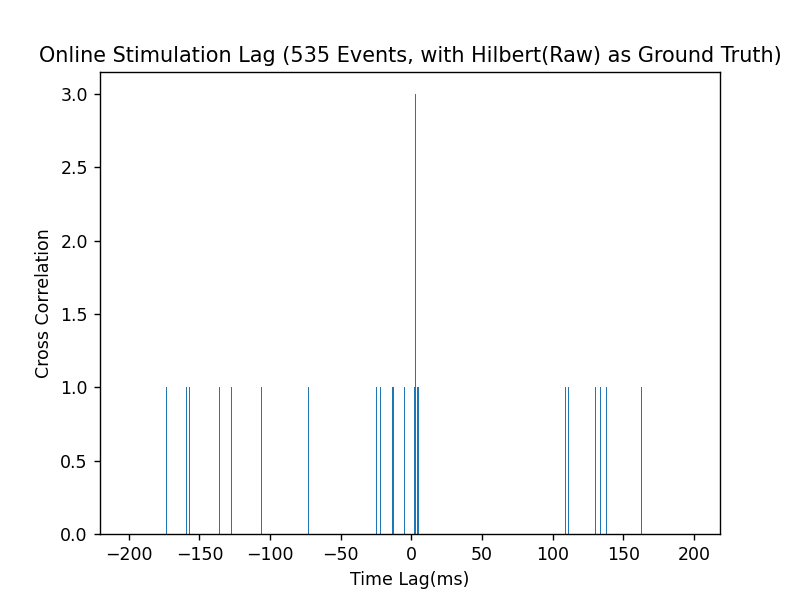

Text(0.5, 1.0, 'Online Stimulation Lag (535 Events, with Hilbert(Raw) as Ground Truth)')

In [75]:
offline_hilbert_xcorrhist_raw, offline_hilbert_binedges_raw = np.histogram(offline_hilbert_onlags_raw,range(-200,200))
plt.figure()
plt.bar(offline_hilbert_binedges_raw[:-1],offline_hilbert_xcorrhist_raw)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with Hilbert(Raw) as Ground Truth)'%len(online_rms_truetime))

## 7.3 Cross Correlation - Offline(RMS) and Online(RMS)

In [76]:
offline_rms_onlags = []
for i in range(len(online_rms_truetime)):
    for j in range(len(offline_rms_truetime)):
        offline_rms_onlags.append(round((online_rms_truetime[i]-offline_rms_truetime[j])*1000))

<IPython.core.display.Javascript object>


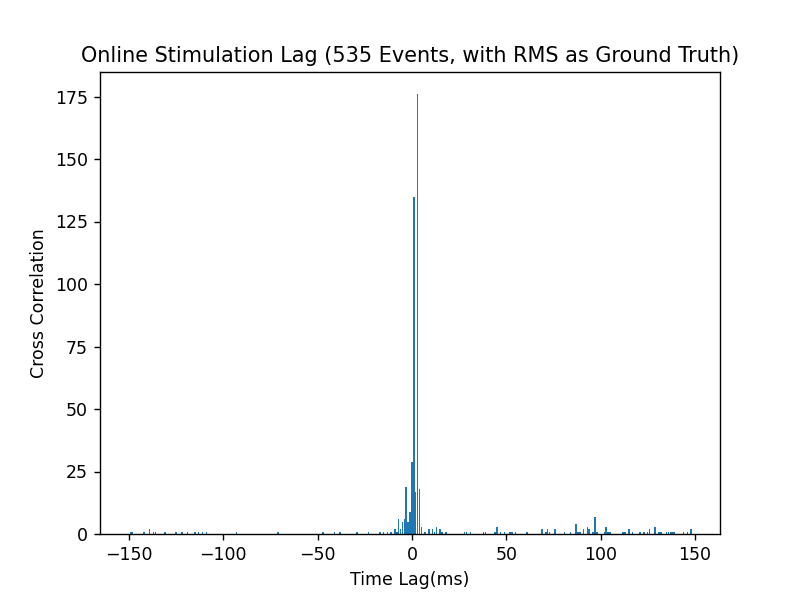

Text(0.5, 1.0, 'Online Stimulation Lag (535 Events, with RMS as Ground Truth)')

In [77]:
offline_rms_xcorrhist, offline_rms_binedges = np.histogram(offline_rms_onlags,range(-150,150))
plt.figure()
plt.bar(offline_rms_binedges[:-1],offline_rms_xcorrhist)
plt.xlabel('Time Lag(ms)')
plt.ylabel('Cross Correlation')
plt.title('Online Stimulation Lag (%d Events, with RMS as Ground Truth)'%len(online_rms_truetime))